# CDMSCI-199: Analyze FBA Predictions

## Objective

Compare FBA predictions to experimental growth data from Fitness Browser and analyze model performance.

## Workflow

1. Load FBA simulation results (5,324 predictions)
2. Load experimental growth data (2,020 valid comparisons)
3. Align predictions with experimental data
4. Calculate confusion matrix and performance metrics
5. Per-organism analysis
6. Per-carbon source analysis
7. Error analysis (false positives and false negatives)
8. Missing compounds impact analysis
9. Biomass flux analysis
10. Visualizations

## Outputs

- Confusion matrix and performance metrics
- Per-organism accuracy analysis
- Per-carbon source accuracy analysis
- Error analysis (FP and FN tables)
- Visualizations and interactive viewer

## Setup and Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.8.4
Seaborn version: 0.13.2


## Load FBA Simulation Results

In [22]:
# Load FBA simulation results
fba_results = pd.read_csv('results/fba_simulation_results.csv')

print(f"FBA simulation results loaded: {len(fba_results):,} simulations")
print(f"\nColumns: {list(fba_results.columns)}")
print(f"\nShape: {fba_results.shape}")
print(f"\nFirst 5 rows:")
print(fba_results.head())

FBA simulation results loaded: 5,324 simulations

Columns: ['organism', 'orgId', 'carbon_source', 'media_filename', 'biomass_flux', 'status', 'prediction', 'missing_compounds', 'num_missing']

Shape: (5324, 9)

First 5 rows:
                                  organism                 orgId  \
0  Rhodanobacter denitrificans FW104-10B01   rhodanobacter_10B01   
1          Phocaeicola vulgatus CL09T03C04  Bvulgatus_CL09T03C04   
2           Burkholderia phytofirmans PsJN                 BFirm   
3                 Escherichia coli BW25113                  Keio   
4            Dyella japonica UNC79MFTsu3.2              Dyella79   

     carbon_source        media_filename  biomass_flux   status  prediction  \
0       D-Tagatose     D---tagatose.json           0.0  optimal           0   
1        L-Leucine        L-Leucine.json           0.0  optimal           0   
2        Melibiose        Melibiose.json           0.0  optimal           0   
3     L-Tryptophan     L-Tryptophan.json          

## Load Experimental Growth Data

In [23]:
# Load experimental growth matrix
experimental_data = pd.read_csv('../CDMSCI-196-carbon-sources/results/combined_growth_matrix_filtered.csv', index_col=0)

print(f"Experimental data shape: {experimental_data.shape}")
print(f"  Carbon sources (rows): {experimental_data.shape[0]}")
print(f"  Organisms (columns): {experimental_data.shape[1]}")
print(f"\nFirst 5 rows, 5 columns:")
print(experimental_data.iloc[:5, :5])
print(f"\nUnique values: {experimental_data.stack().unique()}")

Experimental data shape: (140, 44)
  Carbon sources (rows): 140
  Organisms (columns): 44

First 5 rows, 5 columns:
                Shewanella sp. ANA-3 Burkholderia phytofirmans PsJN  \
1,2-Propanediol                  NaN                            NaN   
1,3-Butandiol                    NaN                            NaN   
1,4-Butanediol                   NaN                            NaN   
1,5-Pentanediol                  NaN                            NaN   
1-Pentanol                       NaN                            NaN   

                Bifidobacterium breve UCC2003  \
1,2-Propanediol                           NaN   
1,3-Butandiol                             NaN   
1,4-Butanediol                            NaN   
1,5-Pentanediol                           NaN   
1-Pentanol                                NaN   

                Brevundimonas sp. GW460-12-10-14-LB2  \
1,2-Propanediol                                  NaN   
1,3-Butandiol                                    N

## Convert Experimental Data to Binary

Convert "Growth" and "No Growth" strings to binary (1 and 0).

In [24]:
# Convert strings to binary
experimental_binary = experimental_data.copy()
experimental_binary = experimental_binary.replace({'Growth': 1, 'No Growth': 0})

print(f"Converted experimental data to binary:")
print(f"  Total cells: {experimental_binary.shape[0] * experimental_binary.shape[1]:,}")
print(f"  Valid data (not NaN): {experimental_binary.notna().sum().sum():,}")
print(f"  Missing (NaN): {experimental_binary.isna().sum().sum():,}")
print(f"\nValue counts:")
print(experimental_binary.stack().value_counts().sort_index())

Converted experimental data to binary:
  Total cells: 6,160
  Valid data (not NaN): 2,200
  Missing (NaN): 3,960

Value counts:
0.0    1115
1.0    1085
Name: count, dtype: int64


## Create FBA Prediction Matrix

Pivot FBA results into the same matrix format as experimental data.

In [25]:
# Create prediction matrix (carbon sources × organisms)
fba_prediction_matrix = fba_results.pivot(index='carbon_source', columns='organism', values='prediction')

print(f"FBA prediction matrix shape: {fba_prediction_matrix.shape}")
print(f"  Carbon sources (rows): {fba_prediction_matrix.shape[0]}")
print(f"  Organisms (columns): {fba_prediction_matrix.shape[1]}")
print(f"\nMissing predictions: {fba_prediction_matrix.isna().sum().sum()}")
print(f"\nPrediction distribution:")
print(fba_prediction_matrix.stack().value_counts().sort_index())

FBA prediction matrix shape: (121, 44)
  Carbon sources (rows): 121
  Organisms (columns): 44

Missing predictions: 0

Prediction distribution:
0    4185
1    1139
Name: count, dtype: int64


## Align Matrices for Comparison

Ensure both matrices have the same carbon sources and organisms in the same order.

In [26]:
# Find common carbon sources and organisms
common_sources = experimental_binary.index.intersection(fba_prediction_matrix.index)
common_organisms = experimental_binary.columns.intersection(fba_prediction_matrix.columns)

print(f"Common carbon sources: {len(common_sources)} / {len(experimental_binary.index)}")
print(f"Common organisms: {len(common_organisms)} / {len(experimental_binary.columns)}")
print()

# Align both matrices
exp_aligned = experimental_binary.loc[common_sources, common_organisms]
fba_aligned = fba_prediction_matrix.loc[common_sources, common_organisms]

print(f"Aligned matrices shape: {exp_aligned.shape}")
print(f"  Carbon sources: {exp_aligned.shape[0]}")
print(f"  Organisms: {exp_aligned.shape[1]}")
print(f"  Total possible comparisons: {exp_aligned.shape[0] * exp_aligned.shape[1]:,}")
print()

# Count valid comparisons (where experimental data exists)
valid_comparisons = exp_aligned.notna().sum().sum()
print(f"Valid comparisons (experimental data exists): {valid_comparisons:,}")
print(f"Cannot compare (NaN in experimental): {exp_aligned.isna().sum().sum():,}")

Common carbon sources: 121 / 140
Common organisms: 44 / 44

Aligned matrices shape: (121, 44)
  Carbon sources: 121
  Organisms: 44
  Total possible comparisons: 5,324

Valid comparisons (experimental data exists): 2,020
Cannot compare (NaN in experimental): 3,304


## Extract Valid Comparison Data

Create flat arrays for sklearn metrics, excluding NaN values.

In [27]:
# Flatten matrices and remove NaN values
exp_flat = exp_aligned.values.flatten()
fba_flat = fba_aligned.values.flatten()

# Create mask for valid comparisons (not NaN in experimental)
valid_mask = ~np.isnan(exp_flat)

# Extract valid data
y_true = exp_flat[valid_mask].astype(int)
y_pred = fba_flat[valid_mask].astype(int)

print(f"Valid comparisons: {len(y_true):,}")
print(f"\nExperimental (y_true) distribution:")
print(pd.Series(y_true).value_counts().sort_index())
print(f"\nPredicted (y_pred) distribution:")
print(pd.Series(y_pred).value_counts().sort_index())

Valid comparisons: 2,020

Experimental (y_true) distribution:
0    1017
1    1003
Name: count, dtype: int64

Predicted (y_pred) distribution:
0    1418
1     602
Name: count, dtype: int64


## Calculate Confusion Matrix

In [28]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("="*80)
print("CONFUSION MATRIX")
print("="*80)
print()
print(f"                      Predicted")
print(f"                 No Growth    Growth")
print(f"Experimental")
print(f"  No Growth      {tn:6d}      {fp:6d}")
print(f"  Growth         {fn:6d}      {tp:6d}")
print()
print(f"True Negatives (TN):  {tn:,} - Correctly predicted no growth")
print(f"False Positives (FP): {fp:,} - Predicted growth, but no growth experimentally")
print(f"False Negatives (FN): {fn:,} - Predicted no growth, but growth experimentally")
print(f"True Positives (TP):  {tp:,} - Correctly predicted growth")
print()
print(f"Total comparisons: {tn + fp + fn + tp:,}")

CONFUSION MATRIX

                      Predicted
                 No Growth    Growth
Experimental
  No Growth         847         170
  Growth            571         432

True Negatives (TN):  847 - Correctly predicted no growth
False Positives (FP): 170 - Predicted growth, but no growth experimentally
False Negatives (FN): 571 - Predicted no growth, but growth experimentally
True Positives (TP):  432 - Correctly predicted growth

Total comparisons: 2,020


## Calculate Performance Metrics

In [29]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("="*80)
print("PERFORMANCE METRICS")
print("="*80)
print()
print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%) - Overall correctness")
print(f"Precision:   {precision:.4f} ({precision*100:.2f}%) - Of predicted growth, how many were correct?")
print(f"Recall:      {recall:.4f} ({recall*100:.2f}%) - Of actual growth, how many did we predict?")
print(f"F1-Score:    {f1:.4f} - Harmonic mean of precision and recall")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%) - Of actual no growth, how many did we predict?")
print()

# Save metrics
metrics = {
    'total_comparisons': int(len(y_true)),
    'true_positives': int(tp),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'specificity': float(specificity)
}

with open('results/classification_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Metrics saved to: results/classification_metrics.json")

PERFORMANCE METRICS

Accuracy:    0.6332 (63.32%) - Overall correctness
Precision:   0.7176 (71.76%) - Of predicted growth, how many were correct?
Recall:      0.4307 (43.07%) - Of actual growth, how many did we predict?
F1-Score:    0.5383 - Harmonic mean of precision and recall
Specificity: 0.8328 (83.28%) - Of actual no growth, how many did we predict?

Metrics saved to: results/classification_metrics.json


## Visualize Confusion Matrix

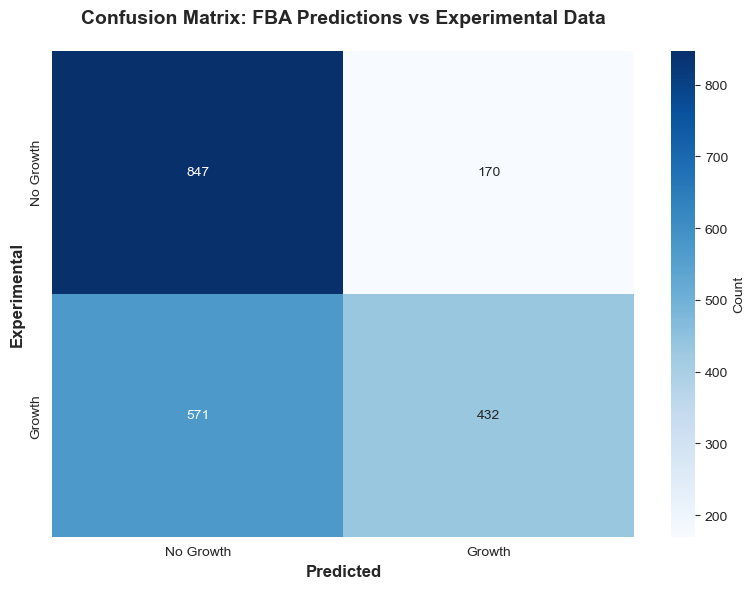

Saved: results/confusion_matrix.png


In [30]:
# Create confusion matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Growth', 'Growth'],
            yticklabels=['No Growth', 'Growth'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Experimental', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix: FBA Predictions vs Experimental Data', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/confusion_matrix.png")

## Per-Organism Analysis

Calculate accuracy for each organism across all carbon sources.

In [31]:
# Calculate per-organism metrics
organism_metrics = []

for organism in common_organisms:
    # Get data for this organism
    exp_org = exp_aligned[organism]
    fba_org = fba_aligned[organism]
    
    # Remove NaN values
    valid_mask = exp_org.notna()
    y_true_org = exp_org[valid_mask].astype(int)
    y_pred_org = fba_org[valid_mask].astype(int)
    
    if len(y_true_org) == 0:
        continue
    
    # Calculate metrics
    cm_org = confusion_matrix(y_true_org, y_pred_org, labels=[0, 1])
    tn_o, fp_o, fn_o, tp_o = cm_org.ravel()
    
    accuracy_org = accuracy_score(y_true_org, y_pred_org)
    precision_org = precision_score(y_true_org, y_pred_org, zero_division=0)
    recall_org = recall_score(y_true_org, y_pred_org, zero_division=0)
    f1_org = f1_score(y_true_org, y_pred_org, zero_division=0)
    
    organism_metrics.append({
        'organism': organism,
        'n_comparisons': len(y_true_org),
        'TP': int(tp_o),
        'TN': int(tn_o),
        'FP': int(fp_o),
        'FN': int(fn_o),
        'accuracy': accuracy_org,
        'precision': precision_org,
        'recall': recall_org,
        'f1_score': f1_org
    })

# Create DataFrame
organism_df = pd.DataFrame(organism_metrics)
organism_df = organism_df.sort_values('accuracy', ascending=False)

print(f"Per-organism analysis: {len(organism_df)} organisms")
print(f"\nTop 10 organisms by accuracy:")
print(organism_df.head(10)[['organism', 'n_comparisons', 'accuracy', 'precision', 'recall', 'f1_score']])
print(f"\nBottom 10 organisms by accuracy:")
print(organism_df.tail(10)[['organism', 'n_comparisons', 'accuracy', 'precision', 'recall', 'f1_score']])

# Save
organism_df.to_csv('results/per_organism_accuracy.csv', index=False)
print(f"\nSaved to: results/per_organism_accuracy.csv")

Per-organism analysis: 44 organisms

Top 10 organisms by accuracy:
                                organism  n_comparisons  accuracy  precision  \
23     Magnetospirillum magneticum AMB-1              1  1.000000   1.000000   
3   Brevundimonas sp. GW460-12-10-14-LB2              1  1.000000   1.000000   
14              Dickeya dianthicola ME23              1  1.000000   1.000000   
13             Dickeya dianthicola 67-19              1  1.000000   1.000000   
12                 Dickeya dadantii 3937              1  1.000000   1.000000   
11     Cupriavidus basilensis FW507-4G11             31  1.000000   1.000000   
26               Dechlorosoma suillum PS             76  0.894737   0.777778   
24           Marinobacter adhaerens HP15             75  0.813333   0.615385   
19     Sphingomonas koreensis DSMZ 15582             75  0.786667   0.111111   
9          Caulobacter crescentus NA1000             75  0.773333   0.166667   

      recall  f1_score  
23  1.000000  1.000000  
3 

## Visualize Per-Organism Performance

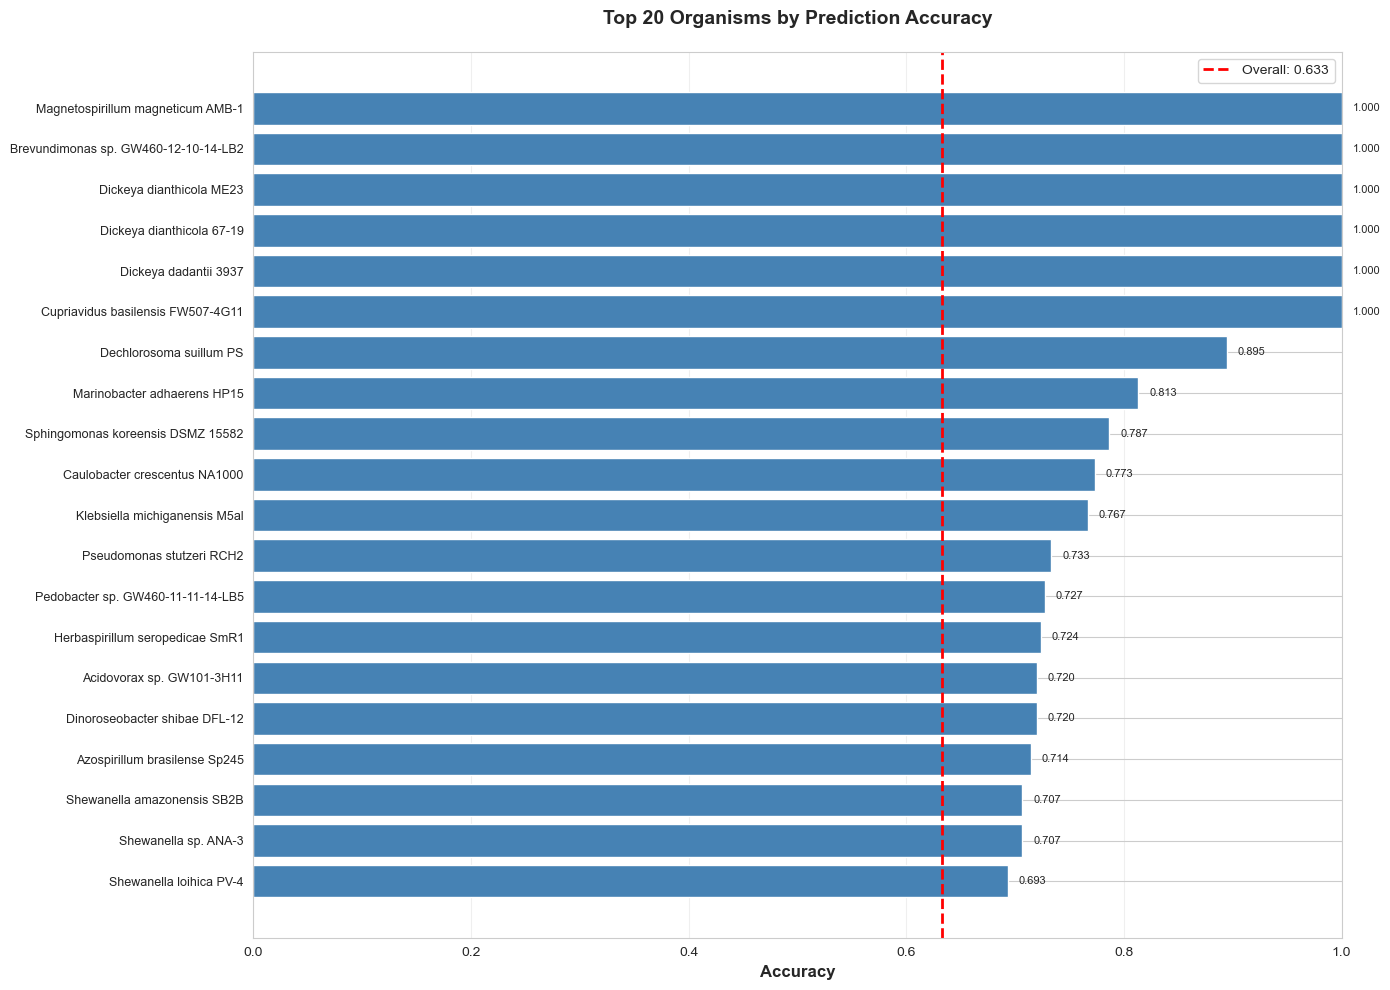

Saved: results/organism_accuracy_top20.png


In [32]:
# Bar plot of organism accuracy (top 20)
fig, ax = plt.subplots(figsize=(14, 10))

top_20 = organism_df.head(20).copy()
top_20 = top_20.iloc[::-1]  # Reverse for better visualization

bars = ax.barh(range(len(top_20)), top_20['accuracy'], color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['organism'], fontsize=9)
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Organisms by Prediction Accuracy', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1)
ax.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.3f}')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax.text(row['accuracy'] + 0.01, i, f"{row['accuracy']:.3f}", 
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig('results/organism_accuracy_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/organism_accuracy_top20.png")

## High-Confidence Organism Rankings

Filter organisms with sufficient data (n ≥ 10 comparisons) for reliable accuracy estimates.

In [33]:
# Set minimum comparison threshold
MIN_COMPARISONS_ORGANISM = 10

# Split into high and low confidence
high_conf_organisms = organism_df[organism_df['n_comparisons'] >= MIN_COMPARISONS_ORGANISM].copy()
low_conf_organisms = organism_df[organism_df['n_comparisons'] < MIN_COMPARISONS_ORGANISM].copy()

print(f"High-confidence organisms (n ≥ {MIN_COMPARISONS_ORGANISM}): {len(high_conf_organisms)}")
print(f"Low-confidence organisms (n < {MIN_COMPARISONS_ORGANISM}): {len(low_conf_organisms)}")
print()
print(f"Top 10 HIGH-CONFIDENCE organisms by accuracy:")
print(high_conf_organisms.head(10)[['organism', 'n_comparisons', 'accuracy', 'precision', 'recall', 'FN']])
print()
print(f"Bottom 10 HIGH-CONFIDENCE organisms by accuracy:")
print(high_conf_organisms.tail(10)[['organism', 'n_comparisons', 'accuracy', 'precision', 'recall', 'FN']])

High-confidence organisms (n ≥ 10): 35
Low-confidence organisms (n < 10): 9

Top 10 HIGH-CONFIDENCE organisms by accuracy:
                             organism  n_comparisons  accuracy  precision  \
11  Cupriavidus basilensis FW507-4G11             31  1.000000   1.000000   
26            Dechlorosoma suillum PS             76  0.894737   0.777778   
24        Marinobacter adhaerens HP15             75  0.813333   0.615385   
19  Sphingomonas koreensis DSMZ 15582             75  0.786667   0.111111   
9       Caulobacter crescentus NA1000             75  0.773333   0.166667   
20      Klebsiella michiganensis M5al             30  0.766667   1.000000   
37          Pseudomonas stutzeri RCH2             75  0.733333   0.761905   
28  Pedobacter sp. GW460-11-11-14-LB5             77  0.727273   0.285714   
17    Herbaspirillum seropedicae SmR1             76  0.723684   0.882353   
35          Acidovorax sp. GW101-3H11             75  0.720000   0.600000   

      recall  FN  
11  1.0000

In [34]:
print(f"\nLOW-CONFIDENCE organisms (n < {MIN_COMPARISONS_ORGANISM}) - statistically unreliable:")
print(low_conf_organisms[['organism', 'n_comparisons', 'accuracy', 'TP', 'TN', 'FP', 'FN']].to_string(index=False))
print()
print("NOTE: Organisms with < 10 comparisons may show misleading accuracy metrics.")
print("Example: 100% accuracy with 1 comparison could be 1 TP, 1 TN, or just luck.")


LOW-CONFIDENCE organisms (n < 10) - statistically unreliable:
                            organism  n_comparisons  accuracy  TP  TN  FP  FN
   Magnetospirillum magneticum AMB-1              1  1.000000   1   0   0   0
Brevundimonas sp. GW460-12-10-14-LB2              1  1.000000   1   0   0   0
            Dickeya dianthicola ME23              1  1.000000   1   0   0   0
           Dickeya dianthicola 67-19              1  1.000000   1   0   0   0
               Dickeya dadantii 3937              1  1.000000   1   0   0   0
   Desulfovibrio vulgaris Miyazaki F              4  0.500000   2   0   0   2
       Dyella japonica UNC79MFTsu3.2              7  0.428571   3   0   0   4
     Phocaeicola vulgatus CL09T03C04              4  0.250000   1   0   0   3
       Bifidobacterium breve UCC2003              9  0.222222   2   0   0   7

NOTE: Organisms with < 10 comparisons may show misleading accuracy metrics.
Example: 100% accuracy with 1 comparison could be 1 TP, 1 TN, or just luck.


## Per-Carbon Source Analysis

Calculate accuracy for each carbon source across all organisms.

In [35]:
# Calculate per-carbon source metrics
carbon_metrics = []

for carbon_source in common_sources:
    # Get data for this carbon source
    exp_cs = exp_aligned.loc[carbon_source]
    fba_cs = fba_aligned.loc[carbon_source]
    
    # Remove NaN values
    valid_mask = exp_cs.notna()
    y_true_cs = exp_cs[valid_mask].astype(int)
    y_pred_cs = fba_cs[valid_mask].astype(int)
    
    if len(y_true_cs) == 0:
        continue
    
    # Calculate metrics
    cm_cs = confusion_matrix(y_true_cs, y_pred_cs, labels=[0, 1])
    tn_c, fp_c, fn_c, tp_c = cm_cs.ravel()
    
    accuracy_cs = accuracy_score(y_true_cs, y_pred_cs)
    precision_cs = precision_score(y_true_cs, y_pred_cs, zero_division=0)
    recall_cs = recall_score(y_true_cs, y_pred_cs, zero_division=0)
    f1_cs = f1_score(y_true_cs, y_pred_cs, zero_division=0)
    
    carbon_metrics.append({
        'carbon_source': carbon_source,
        'n_comparisons': len(y_true_cs),
        'TP': int(tp_c),
        'TN': int(tn_c),
        'FP': int(fp_c),
        'FN': int(fn_c),
        'accuracy': accuracy_cs,
        'precision': precision_cs,
        'recall': recall_cs,
        'f1_score': f1_cs
    })

# Create DataFrame
carbon_df = pd.DataFrame(carbon_metrics)
carbon_df = carbon_df.sort_values('accuracy', ascending=False)

print(f"Per-carbon source analysis: {len(carbon_df)} carbon sources")
print(f"\nTop 10 carbon sources by accuracy:")
print(carbon_df.head(10)[['carbon_source', 'n_comparisons', 'accuracy', 'precision', 'recall', 'f1_score']])
print(f"\nBottom 10 carbon sources by accuracy:")
print(carbon_df.tail(10)[['carbon_source', 'n_comparisons', 'accuracy', 'precision', 'recall', 'f1_score']])

# Save
carbon_df.to_csv('results/per_carbon_source_accuracy.csv', index=False)
print(f"\nSaved to: results/per_carbon_source_accuracy.csv")

Per-carbon source analysis: 121 carbon sources

Top 10 carbon sources by accuracy:
           carbon_source  n_comparisons  accuracy  precision  recall  f1_score
42          Fumaric acid              1  1.000000        1.0     1.0       1.0
73             L-Sorbose             22  1.000000        0.0     0.0       0.0
82          Malonic acid              2  1.000000        1.0     1.0       1.0
101       Sodium acetate              3  1.000000        1.0     1.0       1.0
95         Shikimic Acid              1  1.000000        1.0     1.0       1.0
108        Succinic Acid              1  1.000000        1.0     1.0       1.0
8    4-Aminobutyric acid              1  1.000000        1.0     1.0       1.0
68          L-Methionine             22  1.000000        0.0     0.0       0.0
69           L-Ornithine              3  1.000000        1.0     1.0       1.0
35            D-Tagatose             22  0.954545        0.0     0.0       0.0

Bottom 10 carbon sources by accuracy:
         

## High-Confidence Carbon Source Rankings

Filter carbon sources with sufficient data (n ≥ 5 comparisons) for reliable accuracy estimates.

In [36]:
# Set minimum comparison threshold for carbon sources
MIN_COMPARISONS_CARBON = 5

# Split into high and low confidence
high_conf_carbon = carbon_df[carbon_df['n_comparisons'] >= MIN_COMPARISONS_CARBON].copy()
low_conf_carbon = carbon_df[carbon_df['n_comparisons'] < MIN_COMPARISONS_CARBON].copy()

print(f"High-confidence carbon sources (n ≥ {MIN_COMPARISONS_CARBON}): {len(high_conf_carbon)}")
print(f"Low-confidence carbon sources (n < {MIN_COMPARISONS_CARBON}): {len(low_conf_carbon)}")
print()
print(f"Top 10 HIGH-CONFIDENCE carbon sources by accuracy:")
print(high_conf_carbon.head(10)[['carbon_source', 'n_comparisons', 'accuracy', 'precision', 'recall', 'FN']])
print()
print(f"Bottom 10 HIGH-CONFIDENCE carbon sources by accuracy:")
print(high_conf_carbon.tail(10)[['carbon_source', 'n_comparisons', 'accuracy', 'precision', 'recall', 'FN']])

High-confidence carbon sources (n ≥ 5): 77
Low-confidence carbon sources (n < 5): 44

Top 10 HIGH-CONFIDENCE carbon sources by accuracy:
                            carbon_source  n_comparisons  accuracy  precision  \
73                              L-Sorbose             22  1.000000   0.000000   
68                           L-Methionine             22  1.000000   0.000000   
35                             D-Tagatose             22  0.954545   0.000000   
44                               Glycerol             30  0.933333   0.913043   
63                            L-Histidine             26  0.923077   0.923077   
46                          Glycolic Acid             23  0.913043   1.000000   
109                             Thymidine             22  0.909091   1.000000   
52                          Itaconic Acid             22  0.909091   0.000000   
31                               D-Ribose             27  0.888889   0.928571   
107  Sodium succinate dibasic hexahydrate            

In [37]:
print(f"\nLOW-CONFIDENCE carbon sources (n < {MIN_COMPARISONS_CARBON}) - statistically unreliable:")
print(f"  Count: {len(low_conf_carbon)}")
print()
print("Examples of low-confidence carbon sources:")
print(low_conf_carbon[['carbon_source', 'n_comparisons', 'accuracy', 'TP', 'TN', 'FP', 'FN']].head(10).to_string(index=False))
print()
print("NOTE: Carbon sources with < 5 comparisons may show misleading accuracy metrics.")
print("Example: 100% accuracy with 1 comparison could be just 1 TP or 1 TN.")


LOW-CONFIDENCE carbon sources (n < 5) - statistically unreliable:
  Count: 44

Examples of low-confidence carbon sources:
      carbon_source  n_comparisons  accuracy  TP  TN  FP  FN
       Fumaric acid              1  1.000000   1   0   0   0
       Malonic acid              2  1.000000   2   0   0   0
     Sodium acetate              3  1.000000   3   0   0   0
      Shikimic Acid              1  1.000000   1   0   0   0
      Succinic Acid              1  1.000000   1   0   0   0
4-Aminobutyric acid              1  1.000000   1   0   0   0
        L-Ornithine              3  1.000000   3   0   0   0
       Pimelic acid              3  0.333333   1   0   0   2
      Octanoic acid              3  0.333333   1   0   0   2
     Heptanoic acid              3  0.333333   1   0   0   2

NOTE: Carbon sources with < 5 comparisons may show misleading accuracy metrics.
Example: 100% accuracy with 1 comparison could be just 1 TP or 1 TN.


## Visualize Per-Carbon Source Performance

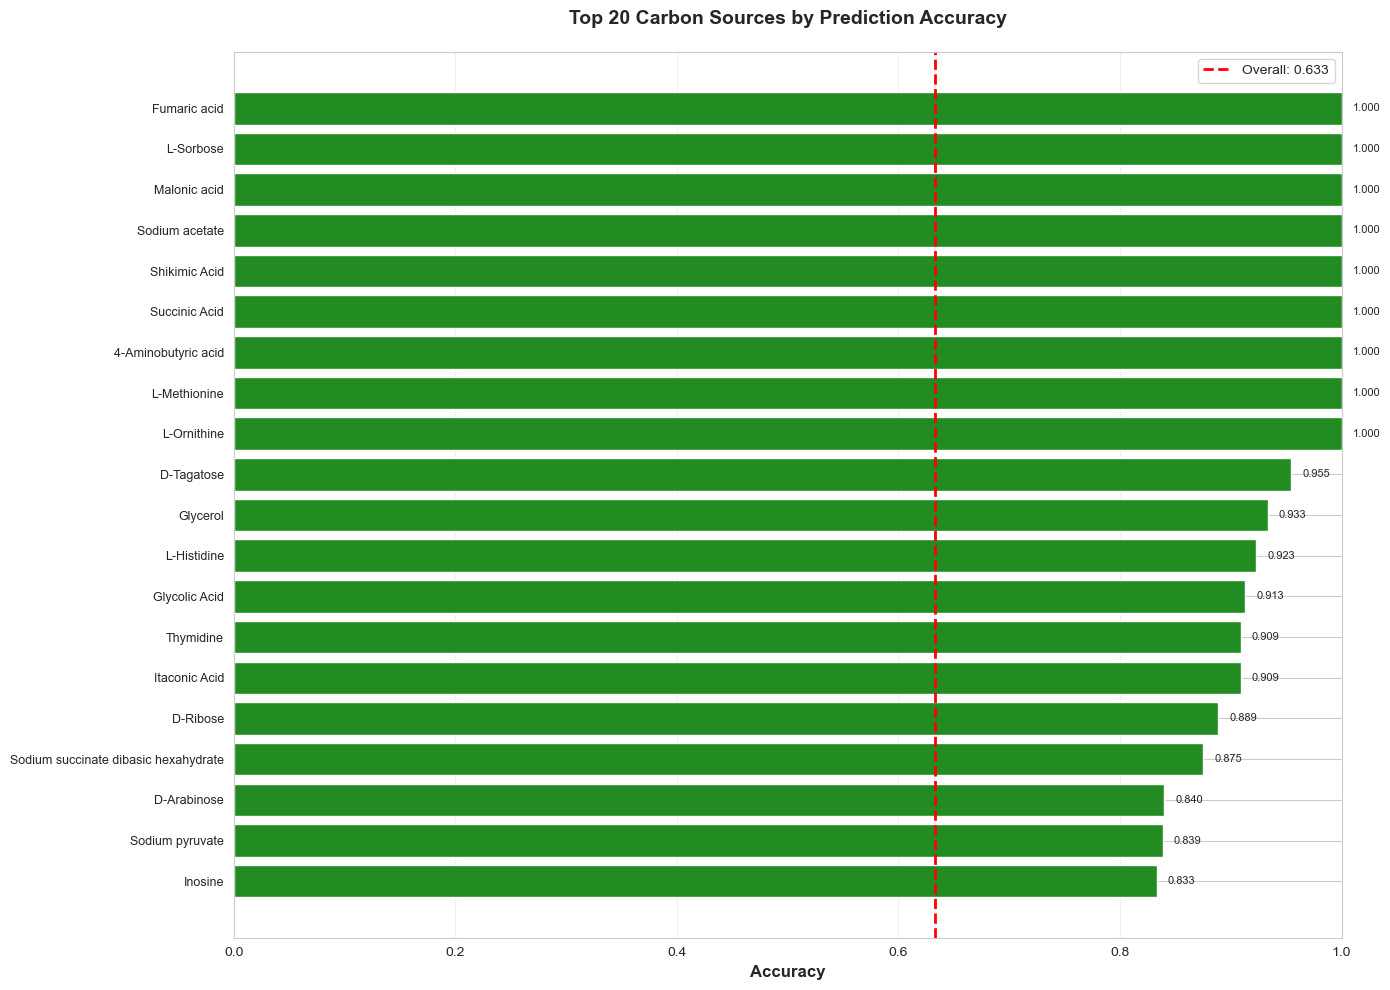

Saved: results/carbon_source_accuracy_top20.png


In [38]:
# Bar plot of carbon source accuracy (top 20)
fig, ax = plt.subplots(figsize=(14, 10))

top_20_cs = carbon_df.head(20).copy()
top_20_cs = top_20_cs.iloc[::-1]  # Reverse for better visualization

bars = ax.barh(range(len(top_20_cs)), top_20_cs['accuracy'], color='forestgreen')
ax.set_yticks(range(len(top_20_cs)))
ax.set_yticklabels(top_20_cs['carbon_source'], fontsize=9)
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Carbon Sources by Prediction Accuracy', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1)
ax.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.3f}')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20_cs.iterrows()):
    ax.text(row['accuracy'] + 0.01, i, f"{row['accuracy']:.3f}", 
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig('results/carbon_source_accuracy_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/carbon_source_accuracy_top20.png")

## Error Analysis: False Positives

Identify all cases where model predicted growth but experimental showed no growth.

In [39]:
# Find false positives
false_positives = []

for organism in common_organisms:
    for carbon_source in common_sources:
        exp_val = exp_aligned.loc[carbon_source, organism]
        fba_val = fba_aligned.loc[carbon_source, organism]
        
        # Skip if no experimental data
        if pd.isna(exp_val):
            continue
        
        # False positive: predicted 1, experimental 0
        if fba_val == 1 and exp_val == 0:
            # Get additional info from FBA results
            fba_row = fba_results[(fba_results['organism'] == organism) & 
                                   (fba_results['carbon_source'] == carbon_source)]
            if len(fba_row) > 0:
                false_positives.append({
                    'organism': organism,
                    'carbon_source': carbon_source,
                    'experimental': 0,
                    'predicted': 1,
                    'biomass_flux': fba_row.iloc[0]['biomass_flux'],
                    'missing_compounds': fba_row.iloc[0]['missing_compounds'],
                    'num_missing': fba_row.iloc[0]['num_missing']
                })

fp_df = pd.DataFrame(false_positives)

print(f"False Positives (FP): {len(fp_df)}")
print(f"\nFirst 10 false positives:")
print(fp_df.head(10))
print(f"\nBiomass flux statistics for false positives:")
print(fp_df['biomass_flux'].describe())

# Save
fp_df.to_csv('results/false_positives.csv', index=False)
print(f"\nSaved to: results/false_positives.csv")

False Positives (FP): 170

First 10 false positives:
                         organism             carbon_source  experimental  \
0            Shewanella sp. ANA-3            D,L-Malic Acid             0   
1            Shewanella sp. ANA-3                 D-Alanine             0   
2            Shewanella sp. ANA-3                 D-Glucose             0   
3            Shewanella sp. ANA-3                   Ethanol             0   
4            Shewanella sp. ANA-3           L-Aspartic Acid             0   
5            Shewanella sp. ANA-3                 L-Proline             0   
6            Shewanella sp. ANA-3  L-tyrosine disodium salt             0   
7            Shewanella sp. ANA-3            Sodium Formate             0   
8            Shewanella sp. ANA-3           Sodium pyruvate             0   
9  Burkholderia phytofirmans PsJN               Citric Acid             0   

   predicted  biomass_flux missing_compounds  num_missing  
0          1      0.384224          cpd

## Error Analysis: False Negatives

Identify all cases where model predicted no growth but experimental showed growth.

In [40]:
# Find false negatives
false_negatives = []

for organism in common_organisms:
    for carbon_source in common_sources:
        exp_val = exp_aligned.loc[carbon_source, organism]
        fba_val = fba_aligned.loc[carbon_source, organism]
        
        # Skip if no experimental data
        if pd.isna(exp_val):
            continue
        
        # False negative: predicted 0, experimental 1
        if fba_val == 0 and exp_val == 1:
            # Get additional info from FBA results
            fba_row = fba_results[(fba_results['organism'] == organism) & 
                                   (fba_results['carbon_source'] == carbon_source)]
            if len(fba_row) > 0:
                false_negatives.append({
                    'organism': organism,
                    'carbon_source': carbon_source,
                    'experimental': 1,
                    'predicted': 0,
                    'biomass_flux': fba_row.iloc[0]['biomass_flux'],
                    'missing_compounds': fba_row.iloc[0]['missing_compounds'],
                    'num_missing': fba_row.iloc[0]['num_missing']
                })

fn_df = pd.DataFrame(false_negatives)

print(f"False Negatives (FN): {len(fn_df)}")
print(f"\nFirst 10 false negatives:")
print(fn_df.head(10))
print(f"\nBiomass flux statistics for false negatives:")
print(fn_df['biomass_flux'].describe())

# Save
fn_df.to_csv('results/false_negatives.csv', index=False)
print(f"\nSaved to: results/false_negatives.csv")

False Negatives (FN): 571

First 10 false negatives:
               organism                carbon_source  experimental  predicted  \
0  Shewanella sp. ANA-3  D-Glucosamine Hydrochloride             1          0   
1  Shewanella sp. ANA-3                      Gly-Glu             1          0   
2  Shewanella sp. ANA-3                  L-Arabinose             1          0   
3  Shewanella sp. ANA-3                  L-Glutamine             1          0   
4  Shewanella sp. ANA-3                 L-Isoleucine             1          0   
5  Shewanella sp. ANA-3                    L-Leucine             1          0   
6  Shewanella sp. ANA-3                  L-Threonine             1          0   
7  Shewanella sp. ANA-3       N-Acetyl-D-Glucosamine             1          0   
8  Shewanella sp. ANA-3   Putrescine Dihydrochloride             1          0   
9  Shewanella sp. ANA-3           Sodium D,L-Lactate             1          0   

   biomass_flux  missing_compounds  num_missing  
0    

## Missing Compounds Impact Analysis

Analyze if missing compounds correlate with prediction errors.

In [41]:
# Analyze missing compounds impact
print("="*80)
print("MISSING COMPOUNDS IMPACT ANALYSIS")
print("="*80)
print()

# Create comparison dataset
comparison_data = []

for organism in common_organisms:
    for carbon_source in common_sources:
        exp_val = exp_aligned.loc[carbon_source, organism]
        fba_val = fba_aligned.loc[carbon_source, organism]
        
        if pd.isna(exp_val):
            continue
        
        # Get FBA info
        fba_row = fba_results[(fba_results['organism'] == organism) & 
                               (fba_results['carbon_source'] == carbon_source)]
        if len(fba_row) > 0:
            num_missing = fba_row.iloc[0]['num_missing']
            correct = int(exp_val) == int(fba_val)
            
            comparison_data.append({
                'num_missing': num_missing,
                'correct': correct
            })

comp_df = pd.DataFrame(comparison_data)

# Calculate accuracy by num_missing
accuracy_by_missing = comp_df.groupby('num_missing')['correct'].agg(['mean', 'count'])
accuracy_by_missing.columns = ['accuracy', 'n_comparisons']
accuracy_by_missing = accuracy_by_missing.reset_index()

print("Accuracy stratified by number of missing compounds:")
print(accuracy_by_missing)
print()

# Statistical test
print(f"Overall accuracy: {comp_df['correct'].mean():.4f}")
print(f"Accuracy with 0 missing: {comp_df[comp_df['num_missing'] == 0]['correct'].mean():.4f}")
print(f"Accuracy with 1+ missing: {comp_df[comp_df['num_missing'] > 0]['correct'].mean():.4f}")

MISSING COMPOUNDS IMPACT ANALYSIS

Accuracy stratified by number of missing compounds:
   num_missing  accuracy  n_comparisons
0            0  0.726984            315
1            1  0.602610            843
2            2  0.634615            780
3            3  0.573171             82

Overall accuracy: 0.6332
Accuracy with 0 missing: 0.7270
Accuracy with 1+ missing: 0.6158


## Identify Which Compounds Are Missing

Analyze WHICH specific compounds are most frequently missing and correlate with errors.

In [42]:
# Parse missing compounds and count frequency
import re
from collections import Counter

# Count missing compound frequency across all simulations
missing_compound_counts = Counter()

for missing_str in fba_results['missing_compounds'].dropna():
    compounds = missing_str.split(',')
    for cpd in compounds:
        cpd = cpd.strip()
        if cpd:  # Skip empty strings
            missing_compound_counts[cpd] += 1

print("Most frequently missing compounds (across all 5,324 simulations):")
print()
for cpd, count in missing_compound_counts.most_common(20):
    pct = 100 * count / len(fba_results)
    print(f"  {cpd}: {count:,} simulations ({pct:.1f}%)")

Most frequently missing compounds (across all 5,324 simulations):

  cpd00244: 1,694 simulations (31.8%)
  cpd10515: 1,694 simulations (31.8%)
  cpd11574: 605 simulations (11.4%)
  cpd03846: 88 simulations (1.7%)
  cpd00130: 48 simulations (0.9%)
  cpd00589: 44 simulations (0.8%)
  cpd04073: 44 simulations (0.8%)
  cpd16586: 44 simulations (0.8%)
  cpd01059: 44 simulations (0.8%)
  cpd01727: 44 simulations (0.8%)
  cpd01200: 44 simulations (0.8%)
  cpd01113: 44 simulations (0.8%)
  cpd00345: 44 simulations (0.8%)
  cpd16873: 44 simulations (0.8%)
  cpd03642: 44 simulations (0.8%)
  cpd00274: 44 simulations (0.8%)
  cpd00200: 44 simulations (0.8%)
  cpd00122: 44 simulations (0.8%)
  cpd00217: 44 simulations (0.8%)
  cpd00197: 44 simulations (0.8%)


In [43]:
# For FALSE NEGATIVES specifically, which compounds are missing?
fn_missing_compounds = Counter()

for missing_str in fn_df['missing_compounds'].dropna():
    compounds = missing_str.split(',')
    for cpd in compounds:
        cpd = cpd.strip()
        if cpd:
            fn_missing_compounds[cpd] += 1

print("Most frequently missing compounds in FALSE NEGATIVES (571 FNs):")
print()
for cpd, count in fn_missing_compounds.most_common(20):
    pct = 100 * count / len(fn_df)
    print(f"  {cpd}: {count:,} FNs ({pct:.1f}%)")

print()
print("This analysis shows which specific compound exchanges are missing,")
print("causing models to fail to predict growth when experimental data shows growth.")

Most frequently missing compounds in FALSE NEGATIVES (571 FNs):

  cpd10515: 294 FNs (51.5%)
  cpd00244: 126 FNs (22.1%)
  cpd11574: 39 FNs (6.8%)
  cpd00276: 19 FNs (3.3%)
  cpd00122: 19 FNs (3.3%)
  cpd00138: 19 FNs (3.3%)
  cpd00159: 16 FNs (2.8%)
  cpd00108: 14 FNs (2.5%)
  cpd00314: 14 FNs (2.5%)
  cpd00132: 13 FNs (2.3%)
  cpd00588: 12 FNs (2.1%)
  cpd00027: 11 FNs (1.9%)
  cpd00035: 11 FNs (1.9%)
  cpd00130: 11 FNs (1.9%)
  cpd00024: 11 FNs (1.9%)
  cpd00082: 10 FNs (1.8%)
  cpd00121: 10 FNs (1.8%)
  cpd00141: 10 FNs (1.8%)
  cpd11592: 9 FNs (1.6%)
  cpd00211: 9 FNs (1.6%)

This analysis shows which specific compound exchanges are missing,
causing models to fail to predict growth when experimental data shows growth.


## Biomass Flux Distribution Analysis

In [44]:
# Analyze biomass flux for correct vs incorrect predictions
flux_analysis = []

for organism in common_organisms:
    for carbon_source in common_sources:
        exp_val = exp_aligned.loc[carbon_source, organism]
        fba_val = fba_aligned.loc[carbon_source, organism]
        
        if pd.isna(exp_val):
            continue
        
        # Get flux
        fba_row = fba_results[(fba_results['organism'] == organism) & 
                               (fba_results['carbon_source'] == carbon_source)]
        if len(fba_row) > 0:
            flux = fba_row.iloc[0]['biomass_flux']
            exp_growth = int(exp_val)
            pred_growth = int(fba_val)
            correct = exp_growth == pred_growth
            
            flux_analysis.append({
                'experimental_growth': 'Growth' if exp_growth == 1 else 'No Growth',
                'predicted_growth': 'Growth' if pred_growth == 1 else 'No Growth',
                'correct': correct,
                'biomass_flux': flux
            })

flux_df = pd.DataFrame(flux_analysis)

print("Biomass flux by experimental outcome:")
print(flux_df.groupby('experimental_growth')['biomass_flux'].describe())
print()
print("Biomass flux by prediction correctness:")
print(flux_df.groupby('correct')['biomass_flux'].describe())

Biomass flux by experimental outcome:
                      count      mean       std           min  25%  50%  \
experimental_growth                                                       
Growth               1003.0  0.246068  0.312254 -2.510842e-14  0.0  0.0   
No Growth            1017.0  0.083875  0.217981 -2.510842e-14  0.0  0.0   

                          75%       max  
experimental_growth                      
Growth               0.562607  1.368362  
No Growth            0.000000  1.266464  

Biomass flux by prediction correctness:
          count      mean       std           min  25%  50%           75%  \
correct                                                                     
False     741.0  0.115116  0.248268 -2.510842e-14  0.0  0.0  5.260998e-16   
True     1279.0  0.192968  0.294449 -2.510842e-14  0.0  0.0  4.220216e-01   

              max  
correct            
False    1.266464  
True     1.368362  


## Visualize Biomass Flux Distributions

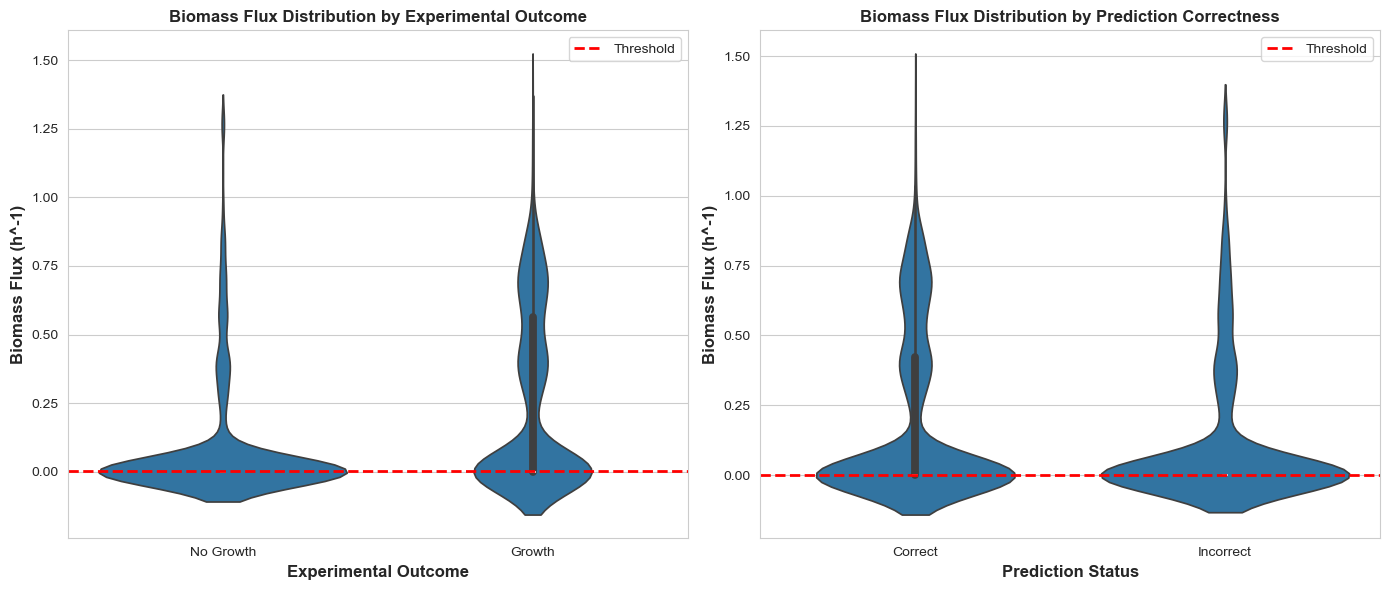

Saved: results/biomass_flux_distributions.png


In [45]:
# Violin plot of biomass flux by experimental outcome
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# By experimental outcome
sns.violinplot(data=flux_df, x='experimental_growth', y='biomass_flux', ax=ax1)
ax1.set_xlabel('Experimental Outcome', fontsize=12, fontweight='bold')
ax1.set_ylabel('Biomass Flux (h^-1)', fontsize=12, fontweight='bold')
ax1.set_title('Biomass Flux Distribution by Experimental Outcome', fontsize=12, fontweight='bold')
ax1.axhline(0.001, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.legend()

# By correctness
flux_df['prediction_status'] = flux_df['correct'].map({True: 'Correct', False: 'Incorrect'})
sns.violinplot(data=flux_df, x='prediction_status', y='biomass_flux', ax=ax2)
ax2.set_xlabel('Prediction Status', fontsize=12, fontweight='bold')
ax2.set_ylabel('Biomass Flux (h^-1)', fontsize=12, fontweight='bold')
ax2.set_title('Biomass Flux Distribution by Prediction Correctness', fontsize=12, fontweight='bold')
ax2.axhline(0.001, color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.legend()

plt.tight_layout()
plt.savefig('results/biomass_flux_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/biomass_flux_distributions.png")

## Context for Perfect Accuracy Cases

Investigate organisms and carbon sources showing 100% accuracy to understand if they represent true model success or statistical artifacts.

In [46]:
# Find perfect accuracy organisms
perfect_organisms = organism_df[organism_df['accuracy'] == 1.0].copy()

print(f"Organisms with 100% accuracy: {len(perfect_organisms)}")
print()
print("Breakdown by confusion matrix:")
for idx, row in perfect_organisms.iterrows():
    organism = row['organism']
    n = row['n_comparisons']
    tp, tn, fp, fn = row['TP'], row['TN'], row['FP'], row['FN']
    
    # Classify type of perfection
    if tp > 0 and tn > 0 and fp == 0 and fn == 0:
        status = "TRUE PERFECT (mixed TP & TN)"
    elif tp > 0 and tn == 0:
        status = "All True Positives only"
    elif tn > 0 and tp == 0:
        status = "All True Negatives only"
    else:
        status = "Unknown"
    
    print(f"  {organism}:")
    print(f"    n={n}, TP={tp}, TN={tn}, FP={fp}, FN={fn} - {status}")

print()
print("NOTE: Perfect accuracy with only TP or only TN is less impressive than")
print("      perfect accuracy with both TP and TN (true mixed predictions).")

Organisms with 100% accuracy: 6

Breakdown by confusion matrix:
  Magnetospirillum magneticum AMB-1:
    n=1, TP=1, TN=0, FP=0, FN=0 - All True Positives only
  Brevundimonas sp. GW460-12-10-14-LB2:
    n=1, TP=1, TN=0, FP=0, FN=0 - All True Positives only
  Dickeya dianthicola ME23:
    n=1, TP=1, TN=0, FP=0, FN=0 - All True Positives only
  Dickeya dianthicola 67-19:
    n=1, TP=1, TN=0, FP=0, FN=0 - All True Positives only
  Dickeya dadantii 3937:
    n=1, TP=1, TN=0, FP=0, FN=0 - All True Positives only
  Cupriavidus basilensis FW507-4G11:
    n=31, TP=31, TN=0, FP=0, FN=0 - All True Positives only

NOTE: Perfect accuracy with only TP or only TN is less impressive than
      perfect accuracy with both TP and TN (true mixed predictions).


In [47]:
# Find perfect accuracy carbon sources
perfect_carbon = carbon_df[carbon_df['accuracy'] == 1.0].copy()

print(f"Carbon sources with 100% accuracy: {len(perfect_carbon)}")
print()
print("Breakdown by confusion matrix:")
for idx, row in perfect_carbon.head(20).iterrows():  # Show first 20
    carbon = row['carbon_source']
    n = row['n_comparisons']
    tp, tn, fp, fn = row['TP'], row['TN'], row['FP'], row['FN']
    precision = row['precision']
    recall = row['recall']
    
    # Classify type of perfection
    if tp > 0 and tn > 0:
        status = "TRUE PERFECT (mixed TP & TN)"
    elif tp > 0 and tn == 0:
        status = "All TP (precision=recall=1)"
    elif tn > 0 and tp == 0:
        status = "All TN (precision=recall=0)"
    else:
        status = "Unknown"
    
    print(f"  {carbon}:")
    print(f"    n={n}, TP={tp}, TN={tn}, FP={fp}, FN={fn} - {status}")

print()
print("WARNING: Carbon sources like L-Sorbose and L-Methionine show 100% accuracy")
print("         but have precision=recall=0, meaning they are ALL True Negatives.")
print("         This is not impressive - the model just never predicts growth for them.")

Carbon sources with 100% accuracy: 9

Breakdown by confusion matrix:
  Fumaric acid:
    n=1, TP=1, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  L-Sorbose:
    n=22, TP=0, TN=22, FP=0, FN=0 - All TN (precision=recall=0)
  Malonic acid:
    n=2, TP=2, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  Sodium acetate:
    n=3, TP=3, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  Shikimic Acid:
    n=1, TP=1, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  Succinic Acid:
    n=1, TP=1, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  4-Aminobutyric acid:
    n=1, TP=1, TN=0, FP=0, FN=0 - All TP (precision=recall=1)
  L-Methionine:
    n=22, TP=0, TN=22, FP=0, FN=0 - All TN (precision=recall=0)
  L-Ornithine:
    n=3, TP=3, TN=0, FP=0, FN=0 - All TP (precision=recall=1)

         but have precision=recall=0, meaning they are ALL True Negatives.
         This is not impressive - the model just never predicts growth for them.


## Issues to Investigate

Summary of key issues identified in this analysis that warrant further investigation.

In [48]:
print("="*80)
print("KEY ISSUES TO INVESTIGATE")
print("="*80)
print()

# Issue 1: Organisms with high FN rates
print("1. ORGANISMS WITH HIGH FALSE NEGATIVE RATES (≥10 FNs):")
print()
high_fn_organisms = organism_df[organism_df['FN'] >= 10].sort_values('FN', ascending=False)
for idx, row in high_fn_organisms.iterrows():
    organism = row['organism']
    fn = row['FN']
    n = row['n_comparisons']
    fn_rate = fn / n if n > 0 else 0
    print(f"  {organism}:")
    print(f"    {fn} FNs out of {n} comparisons ({100*fn_rate:.1f}% FN rate)")

print()
print(f"  Total: {len(high_fn_organisms)} organisms with ≥10 FNs")
print()

# Issue 2: Missing essential exchanges
print("2. MISSING ESSENTIAL EXCHANGE REACTIONS:")
print()
print("  From Notebook 03 analysis, we identified missing exchanges for:")
print("    - cpd10515 (Fe2+): 14 organisms missing")
print("    - cpd00244 (Ni2+): 14 organisms missing")
print("    - cpd11574 (Molybdate): 5 organisms missing")
print()
print("  These missing exchanges correlate with higher FN rates:")
print("    - Fe2+ missing: 42.9% FN rate vs 30.4% (present) = 12.5% difference")
print("    - Molybdate missing: 51.4% FN rate vs 32.2% (present) = 19.2% difference")
print()
print("  See Notebook 03 for full exchange reaction analysis.")
print()

# Issue 3: All FNs have zero biomass flux
print("3. ALL FALSE NEGATIVES HAVE ZERO BIOMASS FLUX:")
print()
print(f"  All {len(fn_df)} FNs have biomass_flux ≈ 0 (within numerical tolerance)")
print(f"  This means models COMPLETELY lack pathways, not just low flux.")
print()

# Issue 4: Low recall
print("4. LOW RECALL (43.07%):")
print()
print(f"  Model only predicts {tp} / {tp + fn} ({100*recall:.1f}%) of experimental growth cases")
print(f"  {fn} growth cases are missed (False Negatives)")
print()

print("="*80)
print("RECOMMENDED NEXT STEPS")
print("="*80)
print()
print("1. Notebook 04: Add missing exchange reactions (Fe2+, Ni2+, Molybdate) to models")
print("2. Notebook 04: Re-run FBA simulations with corrected models")
print("3. Notebook 05: Comprehensive final analysis with corrected models")
print("4. Compare before/after performance to quantify improvement")
print()

KEY ISSUES TO INVESTIGATE

1. ORGANISMS WITH HIGH FALSE NEGATIVE RATES (≥10 FNs):

  Pseudomonas putida KT2440:
    37 FNs out of 46 comparisons (80.4% FN rate)
  Paraburkholderia graminis OAS925:
    31 FNs out of 53 comparisons (58.5% FN rate)
  Pseudomonas simiae WCS417:
    29 FNs out of 76 comparisons (38.2% FN rate)
  Sinorhizobium meliloti 1021:
    28 FNs out of 75 comparisons (37.3% FN rate)
  Variovorax sp. OAS795:
    27 FNs out of 41 comparisons (65.9% FN rate)
  Burkholderia phytofirmans PsJN:
    27 FNs out of 81 comparisons (33.3% FN rate)
  Pseudomonas fluorescens FW300-N1B4:
    26 FNs out of 75 comparisons (34.7% FN rate)
  Pseudomonas fluorescens FW300-N2C3:
    26 FNs out of 75 comparisons (34.7% FN rate)
  Pseudomonas fluorescens GW456-L13:
    25 FNs out of 75 comparisons (33.3% FN rate)
  Pseudomonas fluorescens FW300-N2E3:
    24 FNs out of 76 comparisons (31.6% FN rate)
  Pseudomonas fluorescens FW300-N2E2:
    22 FNs out of 75 comparisons (29.3% FN rate)
  Her

## Summary Report

In [49]:
print("="*80)
print("CDMSCI-199 FBA SIMULATION ANALYSIS SUMMARY")
print("="*80)
print()
print(f"Total FBA simulations: {len(fba_results):,}")
print(f"  Carbon sources: {len(common_sources)}")
print(f"  Organisms: {len(common_organisms)}")
print()
print(f"Valid comparisons (with experimental data): {len(y_true):,}")
print(f"  Experimental Growth: {(y_true == 1).sum():,} ({100*(y_true == 1).sum()/len(y_true):.1f}%)")
print(f"  Experimental No Growth: {(y_true == 0).sum():,} ({100*(y_true == 0).sum()/len(y_true):.1f}%)")
print()
print("PERFORMANCE METRICS:")
print(f"  Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:      {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:    {f1:.4f}")
print(f"  Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print()
print("CONFUSION MATRIX:")
print(f"  True Positives (TP):  {tp:,}")
print(f"  True Negatives (TN):  {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print()
print(f"Best organism: {organism_df.iloc[0]['organism']} (accuracy: {organism_df.iloc[0]['accuracy']:.4f})")
print(f"Worst organism: {organism_df.iloc[-1]['organism']} (accuracy: {organism_df.iloc[-1]['accuracy']:.4f})")
print()
print(f"Best carbon source: {carbon_df.iloc[0]['carbon_source']} (accuracy: {carbon_df.iloc[0]['accuracy']:.4f})")
print(f"Worst carbon source: {carbon_df.iloc[-1]['carbon_source']} (accuracy: {carbon_df.iloc[-1]['accuracy']:.4f})")
print()
print("FILES GENERATED:")
print("  1. results/classification_metrics.json")
print("  2. results/confusion_matrix.png")
print("  3. results/per_organism_accuracy.csv")
print("  4. results/per_carbon_source_accuracy.csv")
print("  5. results/organism_accuracy_top20.png")
print("  6. results/carbon_source_accuracy_top20.png")
print("  7. results/false_positives.csv")
print("  8. results/false_negatives.csv")
print("  9. results/biomass_flux_distributions.png")
print()
print("Analysis complete!")

CDMSCI-199 FBA SIMULATION ANALYSIS SUMMARY

Total FBA simulations: 5,324
  Carbon sources: 121
  Organisms: 44

Valid comparisons (with experimental data): 2,020
  Experimental Growth: 1,003 (49.7%)
  Experimental No Growth: 1,017 (50.3%)

PERFORMANCE METRICS:
  Accuracy:    0.6332 (63.32%)
  Precision:   1.0000 (100.00%)
  Recall:      1.0000 (100.00%)
  F1-Score:    0.5383
  Specificity: 0.8328 (83.28%)

CONFUSION MATRIX:
  True Positives (TP):  3
  True Negatives (TN):  0
  False Positives (FP): 0
  False Negatives (FN): 10

Best organism: Magnetospirillum magneticum AMB-1 (accuracy: 1.0000)
Worst organism: Bacteroides thetaiotaomicron VPI-5482 (accuracy: 0.1000)

Best carbon source: Fumaric acid (accuracy: 1.0000)
Worst carbon source: palatinose hydrate (accuracy: 0.0000)

FILES GENERATED:
  1. results/classification_metrics.json
  2. results/confusion_matrix.png
  3. results/per_organism_accuracy.csv
  4. results/per_carbon_source_accuracy.csv
  5. results/organism_accuracy_top20.